In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src.data.prepare_data import Data
from src.model.hparams import config
from src.model.scaled_dot_product_attention import ScaledDotProductAttention
from src.utils.shared_embedding import create_pretrained_embedding

C:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\ml-hw3-6sem-STruoplB-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Инициализация

In [2]:
# Загрузка предобученных эмбеддингов
embedding_path = str(Path(os.getcwd()).parent / "embeddings" / "navec_hudlit_v1_12B_500K_300d_100q.tar")
shared_embedding, embedding_model, pad_idx, unk_idx = create_pretrained_embedding(path=embedding_path)

data = Data(embedding_model)

C:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\ml-hw3-6sem-STruoplB-py3.12\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [3]:
# Инициализация словаря
data_path = str(Path(os.getcwd()).parent / "data" / "news.csv")
train_iter, test_iter = data.init_dataset(
    csv_path=data_path,
    batch_sizes=(config["train_batch_size"], config["test_batch_size"]),
    split_ratio=config["data_split_ratio"],
)
vocab = data.word_field.vocab

Creating datasets: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74278/74278 [00:14<00:00, 4986.52it/s]
2025-05-27 13:28:21,562 - prepare_data - INFO - Train size = 73535
2025-05-27 13:28:21,563 - prepare_data - INFO - Test size = 743
2025-05-27 13:28:21,976 - prepare_data - INFO - Vocab size = 500004


In [6]:
# Cuda or CPU
device = torch.device("cpu")
print(device)

# Инициализация проекций
d_model = 300
num_heads = 2
head_dim = d_model // num_heads

# Attention
attention = ScaledDotProductAttention(dropout_rate=0.0).to(device)

cpu


# Первый пример

In [8]:
source_text = "Я не хочу сдавать письменный экзамен по математической физике."

# Токенизация и числовое представление
tokenized = data.word_field.preprocess(source_text)
print(f"Tokenized: {tokenized}")

numericalized = [vocab.stoi.get(token, unk_idx) for token in tokenized]
source_inputs = torch.tensor(numericalized, dtype=torch.long, device=device).unsqueeze(0)
source_mask = (source_inputs != unk_idx) & (source_inputs != pad_idx)
mask = source_mask

embedded_inputs = shared_embedding(source_inputs).to(device)

# Подготовка для multi-head attention
batch_size, seq_len, emb_dim = embedded_inputs.shape
num_heads = 2

query = key = value = embedded_inputs
query = query.unsqueeze(1).expand(-1, num_heads, -1, -1)
key = key.unsqueeze(1).expand(-1, num_heads, -1, -1)
value = value.unsqueeze(1).expand(-1, num_heads, -1, -1)

# Debug info
print("Уникальные слова в предложении:", set(tokenized))
print("Есть ли OOV?:", [token for token in tokenized if token not in embedding_model])
print("Нормы эмбеддингов:", torch.norm(embedded_inputs, dim=-1))

print("source_mask:", source_mask)  # Должно быть True для всех токенов, кроме pad_idx

print("query shape:", query.shape)
print("key shape:", key.shape)
print("value shape:", value.shape)
print("mask shape:", mask.shape if mask is not None else "No mask")

Tokenized: ['я', 'не', 'хочу', 'сдавать', 'письменный', 'экзамен', 'по', 'математической', 'физике']
Уникальные слова в предложении: {'не', 'экзамен', 'хочу', 'математической', 'я', 'физике', 'по', 'сдавать', 'письменный'}
Есть ли OOV?: []
Нормы эмбеддингов: tensor([[5.2685, 4.4707, 5.1793, 5.9158, 6.2487, 6.2294, 5.8254, 6.1505, 5.9251]],
       grad_fn=<LinalgVectorNormBackward0>)
source_mask: tensor([[True, True, True, True, True, True, True, True, True]])
query shape: torch.Size([1, 2, 9, 300])
key shape: torch.Size([1, 2, 9, 300])
value shape: torch.Size([1, 2, 9, 300])
mask shape: torch.Size([1, 9])


In [9]:
# Attention
attn_output, attn_weights = attention(query, key, value, mask=mask)

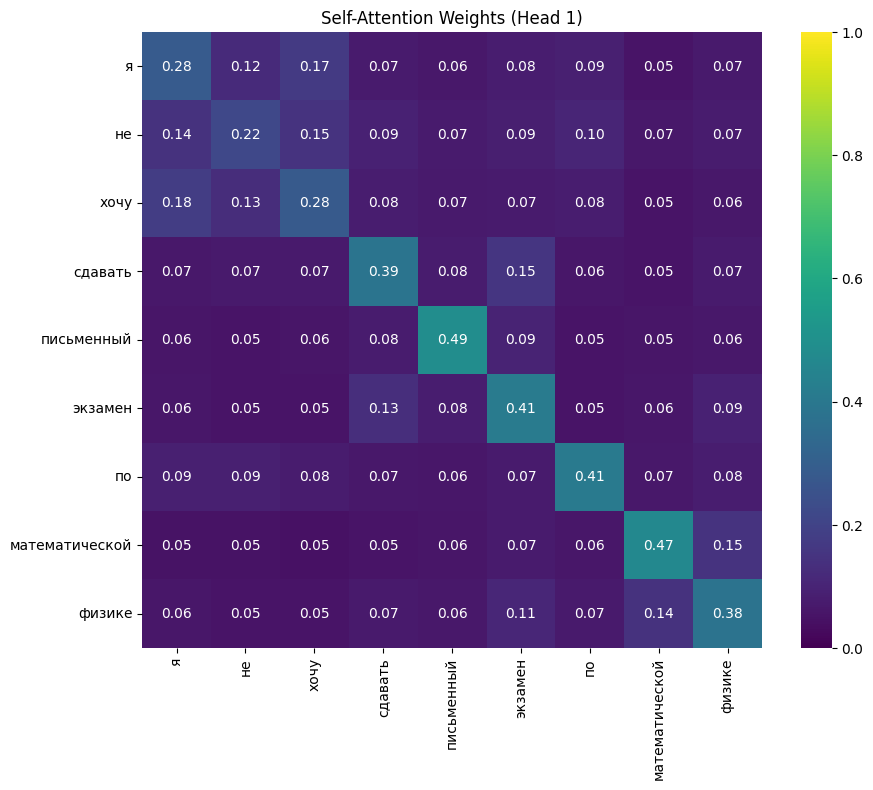

In [10]:
# Визуализация
first_head_weights = attn_weights[0, 0].detach().cpu().numpy()
tokens = tokenized
if len(tokens) < first_head_weights.shape[0]:
    first_head_weights = first_head_weights[: len(tokens), : len(tokens)]

plt.figure(figsize=(10, 8))
sns.heatmap(
    first_head_weights, annot=True, xticklabels=tokens, yticklabels=tokens, cmap="viridis", fmt=".2f", vmin=0, vmax=1
)
plt.title("Self-Attention Weights (Head 1)")
plt.show()

# Второй пример

In [11]:
source_text = "Вероятность встретить динозавра на улице на самом деле не нулевая, а целых 50 процентов."

# Токенизация и числовое представление
tokenized = data.word_field.preprocess(source_text)
print(f"Tokenized: {tokenized}")

numericalized = [vocab.stoi.get(token, unk_idx) for token in tokenized]
source_inputs = torch.tensor(numericalized, dtype=torch.long, device=device).unsqueeze(0)
source_mask = (source_inputs != unk_idx) & (source_inputs != pad_idx)
mask = source_mask

embedded_inputs = shared_embedding(source_inputs).to(device)

# Подготовка для multi-head attention
batch_size, seq_len, emb_dim = embedded_inputs.shape
num_heads = 2

query = key = value = embedded_inputs
query = query.unsqueeze(1).expand(-1, num_heads, -1, -1)
key = key.unsqueeze(1).expand(-1, num_heads, -1, -1)
value = value.unsqueeze(1).expand(-1, num_heads, -1, -1)

# Debug info
print("Уникальные слова в предложении:", set(tokenized))
print("Есть ли OOV?:", [token for token in tokenized if token not in embedding_model])
print("Нормы эмбеддингов:", torch.norm(embedded_inputs, dim=-1))

print("source_mask:", source_mask)  # Должно быть True для всех токенов, кроме pad_idx

print("query shape:", query.shape)
print("key shape:", key.shape)
print("value shape:", value.shape)
print("mask shape:", mask.shape if mask is not None else "No mask")

Tokenized: ['вероятность', 'встретить', 'динозавра', 'на', 'улице', 'на', 'самом', 'деле', 'не', 'нулевая', 'а', 'целых', '<unk>', 'процентов']
Уникальные слова в предложении: {'самом', 'процентов', 'вероятность', 'деле', '<unk>', 'нулевая', 'целых', 'динозавра', 'на', 'улице', 'а', 'не', 'встретить'}
Есть ли OOV?: []
Нормы эмбеддингов: tensor([[6.2136, 5.6443, 5.0419, 5.5666, 5.9931, 5.5666, 4.6140, 4.4104, 4.4707,
         5.3178, 3.7162, 5.4524, 2.5910, 5.8966]],
       grad_fn=<LinalgVectorNormBackward0>)
source_mask: tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False,  True]])
query shape: torch.Size([1, 2, 14, 300])
key shape: torch.Size([1, 2, 14, 300])
value shape: torch.Size([1, 2, 14, 300])
mask shape: torch.Size([1, 14])


In [12]:
# Attention
attn_output, attn_weights = attention(query, key, value, mask=mask)

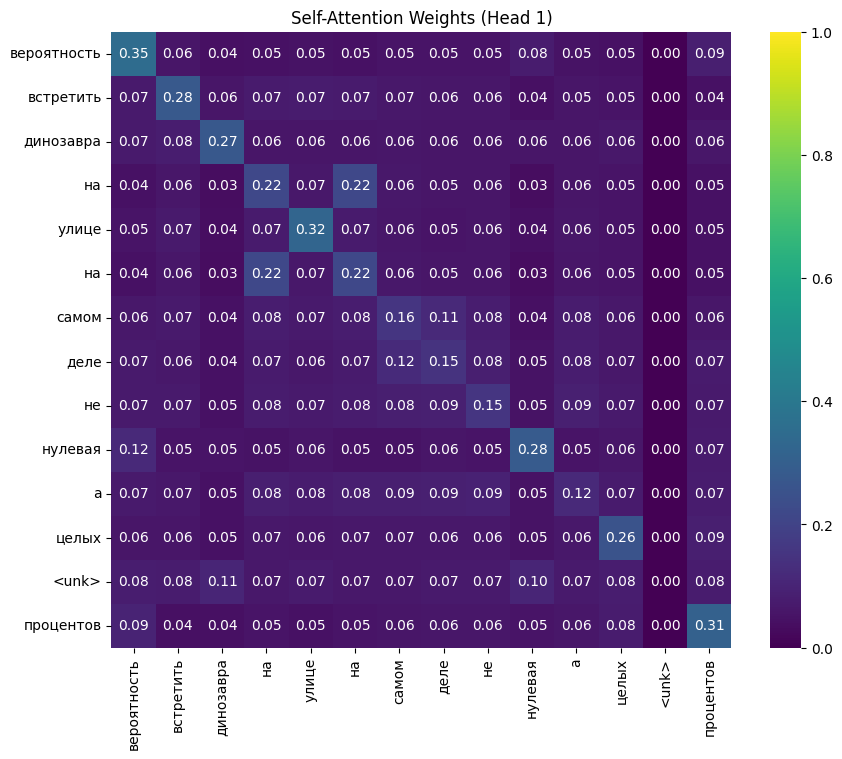

In [13]:
# Визуализация
first_head_weights = attn_weights[0, 0].detach().cpu().numpy()
tokens = tokenized
if len(tokens) < first_head_weights.shape[0]:
    first_head_weights = first_head_weights[: len(tokens), : len(tokens)]

plt.figure(figsize=(10, 8))
sns.heatmap(
    first_head_weights, annot=True, xticklabels=tokens, yticklabels=tokens, cmap="viridis", fmt=".2f", vmin=0, vmax=1
)
plt.title("Self-Attention Weights (Head 1)")
plt.show()

# Третий пример

In [14]:
source_text = "Хочу кушать и спать, пустите, пожалуйста, на каникулы."

# Токенизация и числовое представление
tokenized = data.word_field.preprocess(source_text)
print(f"Tokenized: {tokenized}")

numericalized = [vocab.stoi.get(token, unk_idx) for token in tokenized]
source_inputs = torch.tensor(numericalized, dtype=torch.long, device=device).unsqueeze(0)
source_mask = (source_inputs != unk_idx) & (source_inputs != pad_idx)
mask = source_mask

embedded_inputs = shared_embedding(source_inputs).to(device)

# Подготовка для multi-head attention
batch_size, seq_len, emb_dim = embedded_inputs.shape
num_heads = 2

query = key = value = embedded_inputs
query = query.unsqueeze(1).expand(-1, num_heads, -1, -1)
key = key.unsqueeze(1).expand(-1, num_heads, -1, -1)
value = value.unsqueeze(1).expand(-1, num_heads, -1, -1)

# Debug info
print("Уникальные слова в предложении:", set(tokenized))
print("Есть ли OOV?:", [token for token in tokenized if token not in embedding_model])
print("Нормы эмбеддингов:", torch.norm(embedded_inputs, dim=-1))

print("source_mask:", source_mask)  # Должно быть True для всех токенов, кроме pad_idx

print("query shape:", query.shape)
print("key shape:", key.shape)
print("value shape:", value.shape)
print("mask shape:", mask.shape if mask is not None else "No mask")

Tokenized: ['хочу', 'кушать', 'и', 'спать', 'пустите', 'пожалуйста', 'на', 'каникулы']
Уникальные слова в предложении: {'и', 'хочу', 'пустите', 'каникулы', 'спать', 'кушать', 'на', 'пожалуйста'}
Есть ли OOV?: []
Нормы эмбеддингов: tensor([[5.1793, 5.3629, 3.6682, 6.0477, 5.5373, 6.0311, 5.5666, 5.7696]],
       grad_fn=<LinalgVectorNormBackward0>)
source_mask: tensor([[True, True, True, True, True, True, True, True]])
query shape: torch.Size([1, 2, 8, 300])
key shape: torch.Size([1, 2, 8, 300])
value shape: torch.Size([1, 2, 8, 300])
mask shape: torch.Size([1, 8])


In [15]:
# Attention
attn_output, attn_weights = attention(query, key, value, mask=mask)

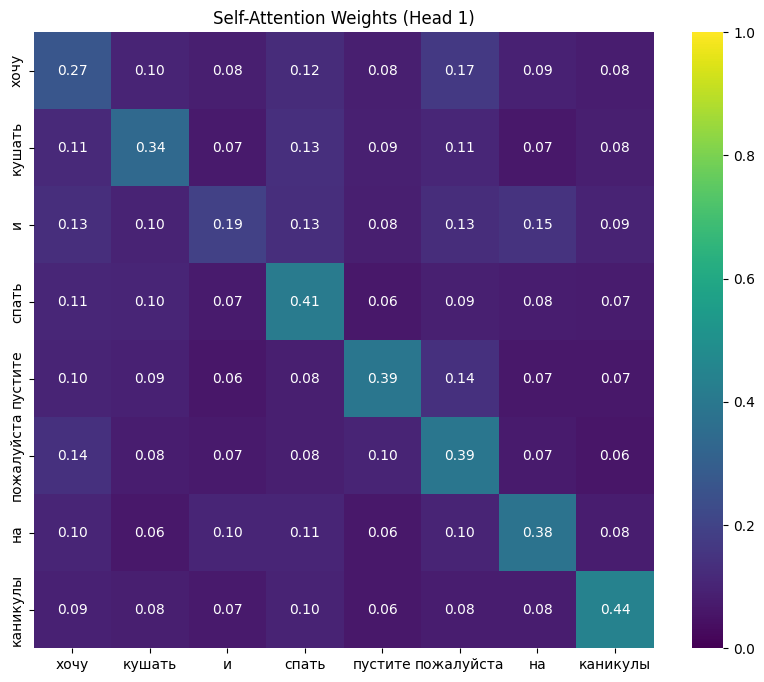

In [16]:
# Визуализация
first_head_weights = attn_weights[0, 0].detach().cpu().numpy()
tokens = tokenized
if len(tokens) < first_head_weights.shape[0]:
    first_head_weights = first_head_weights[: len(tokens), : len(tokens)]

plt.figure(figsize=(10, 8))
sns.heatmap(
    first_head_weights, annot=True, xticklabels=tokens, yticklabels=tokens, cmap="viridis", fmt=".2f", vmin=0, vmax=1
)
plt.title("Self-Attention Weights (Head 1)")
plt.show()